In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import MultipleLocator

import pandas as pd
import numpy as np
import tqdm
import seaborn as sns; sns.set()
sns.__version__

import pickle

In [2]:
sns.set_style("ticks", {"xtick.major.size":15,"ytick.major.size":15})

plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42

%config InlineBackend.figure_format = 'retina'

In [3]:
# Source: http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_%28ggplot2%29/
# Produces count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   conf_interval: the percent range of the confidence interval (default is 95%)

import scipy as sp
from scipy.stats import t

def summarySE(data, measurevar, groupvars, conf_interval=0.95):
    def std(s):
        return np.std(s, ddof=1)
    def stde(s):
        return std(s) / np.sqrt(len(s))
    def ci(s):
        # Confidence interval multiplier for standard error
        # Calculate t-statistic for confidence interval: 
        # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
        ciMult = t.ppf(conf_interval/2.0 + .5, len(s)-1)
        return stde(s)*ciMult
    def ciUpper(s):
        return np.mean(s)+ci(s)
    def ciLower(s):
        return np.mean(s)-ci(s)
    
    data = data[groupvars+measurevar].groupby(groupvars).agg([len, np.mean, std, stde, ciUpper, ciLower, ci])

    data.reset_index(inplace=True)

    data.columns = groupvars+['_'.join(col).strip() for col in data.columns.values[len(groupvars):]]

    return data

In [4]:
df_paper_1985_2009 = pd.read_pickle('/data/interdisciplinarity/df_paper_1985_2009.pkl')
df_grant_1985_2009 = pd.read_pickle('/data/interdisciplinarity/df_grant_1985_2009.pkl')
df_pair_1985_2009 = pd.read_pickle('/data/interdisciplinarity/df_pair_1985_2009.pkl')

In [5]:
with open('/data/sci_of_sci/linkage/d_paper_fos.pkl', 'rb') as filename:
    d_paper_fos = pickle.load(filename)

In [6]:
df_paper_1985_2009['mag_id'] = df_paper_1985_2009['mag_id'].apply(str)

In [8]:
df_paper_1985_2009['num_fos'] = df_paper_1985_2009['mag_id'].apply(lambda x: d_paper_fos.get(x)).str.len()

In [9]:
def createList(r1, r2, interval):
    return np.arange(r1, r2+interval, interval)

df_paper_1985_2009['num_fos_percentile'] = df_paper_1985_2009['num_fos'].rank(pct=True)

c = pd.cut(
    df_paper_1985_2009['num_fos_percentile'],
    list(createList(0.0,1.0,0.25)),
    labels=list(createList(0,100,25))[1:]
)

df_paper_1985_2009['num_fos_interval'] = c

In [14]:
#####----- A -----#####
numFOS_per_year = summarySE(df_paper_1985_2009, ['num_fos'], ['pub_year'])
paperITD_per_year = summarySE(df_paper_1985_2009, ['interdisciplinarity_reference'], ['pub_year'])
np.corrcoef(numFOS_per_year['num_fos_mean'],paperITD_per_year['interdisciplinarity_reference_mean'])

array([[1.        , 0.92863404],
       [0.92863404, 1.        ]])

In [12]:
#####----- B -----#####
df_tmp = df_paper_1985_2009[['interdisciplinarity_reference','num_fos_interval','pub_year']]
paperITD_per_year_num_fos = summarySE(df_tmp, ['interdisciplinarity_reference'],
                                      ['num_fos_interval','pub_year'])

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


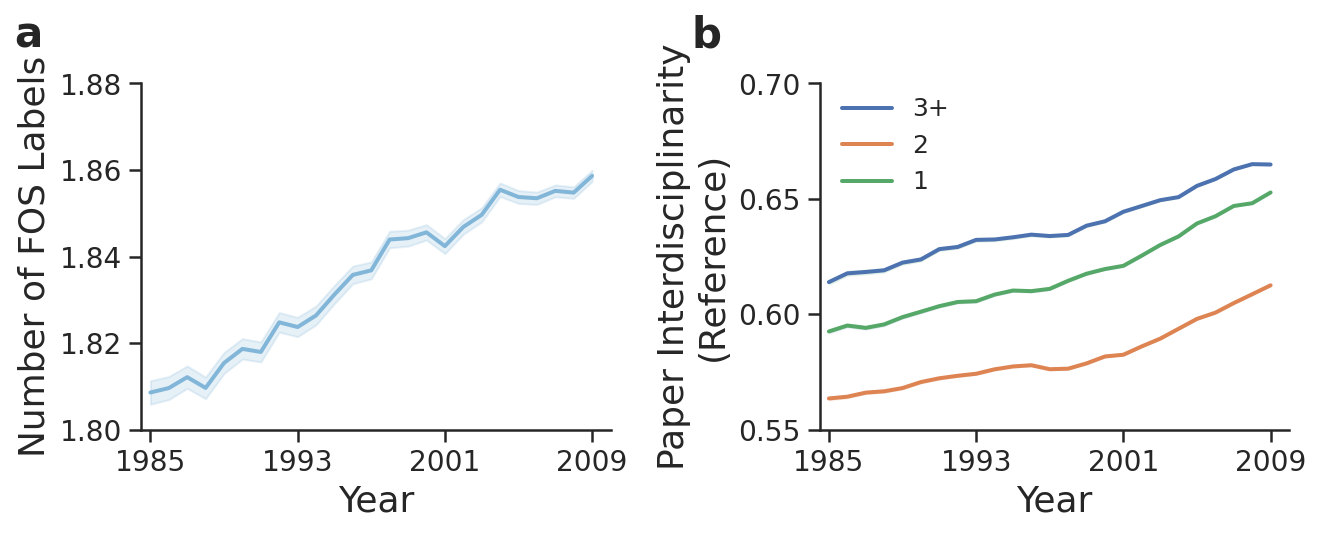

In [16]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch

fig = plt.figure(figsize=(14*(2/3),4))
gs = GridSpec(1, 2, figure=fig)

#####----- A -----#####
ax = fig.add_subplot(gs[0,0])

c1 = '#82b6d9'

x1 = numFOS_per_year['pub_year']
mu1 = numFOS_per_year['num_fos_mean']
ci1 = numFOS_per_year['num_fos_ci']

ax.plot(x1, mu1, lw=2, label='All', color=c1)
ax.fill_between(x1, mu1+ci1, mu1-ci1, facecolor='C0', alpha=0.2, color=c1)

ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Number of FOS Labels', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.yticks([1.80, 1.82, 1.84, 1.86, 1.88])
ax.set_yticklabels(['1.80', '1.82', '1.84', '1.86', '1.88'])
plt.ylim(1.80, 1.88)
plt.xticks([1985, 1993, 2001, 2009])
ax.set_xticklabels(['1985', '1993', '2001', '2009'])
plt.xlim(1984.5, 2010)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'a', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- B -----#####
ax = fig.add_subplot(gs[0,1])

tmp_x = []
tmp_mu = []
tmp_ci = []
for i in [25,75,100]:
    tmp_x.append(paperITD_per_year_num_fos[paperITD_per_year_num_fos['num_fos_interval']==i]['pub_year'])
    tmp_mu.append(paperITD_per_year_num_fos[paperITD_per_year_num_fos['num_fos_interval']==i]['interdisciplinarity_reference_mean'])
    tmp_ci.append(paperITD_per_year_num_fos[paperITD_per_year_num_fos['num_fos_interval']==i]['interdisciplinarity_reference_ci'])

for i,label in reversed(list(enumerate(['1','2','3+']))):
    ax.plot(tmp_x[i], tmp_mu[i], lw=2, label=label)
    ax.fill_between(tmp_x[i], tmp_mu[i]+tmp_ci[i], tmp_mu[i]-tmp_ci[i],
                    facecolor='C{}'.format(i), alpha=0.2)

ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Paper Interdisciplinarity\n(Reference)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.xticks([1985, 1993, 2001, 2009])
ax.set_xticklabels(['1985', '1993', '2001', '2009'])
plt.xlim(1984.5, 2010)
plt.yticks([0.55, 0.60, 0.65, 0.70])
ax.set_yticklabels(['0.55', '0.60', '0.65', '0.70'])
plt.ylim(0.55, 0.70)

ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.025),
          fontsize=12.5, frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'b', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####-------------#####
plt.tight_layout()
plt.show()

fig.savefig('./fig/supp_fig-num-topics.pdf', format='pdf', dpi=700, bbox_inches='tight')

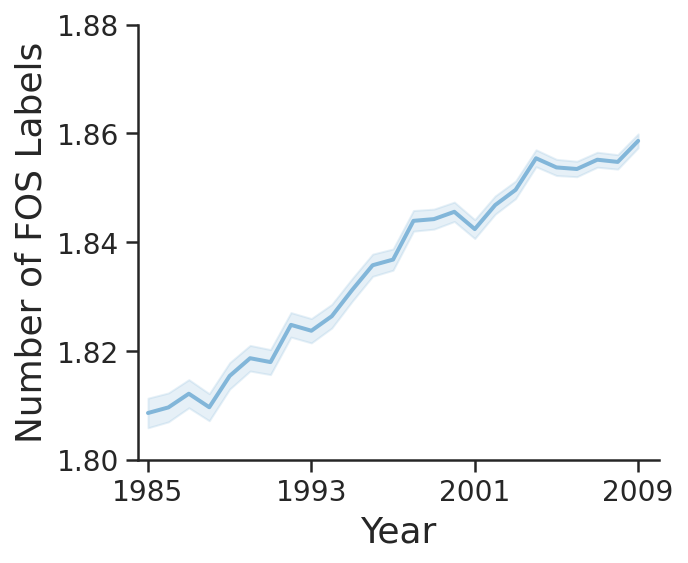

In [34]:
fig, ax = plt.subplots(figsize=(14*(1/3),4))

c1 = '#82b6d9'

x1 = numFOS_per_year['pub_year']
mu1 = numFOS_per_year['num_fos_mean']
ci1 = numFOS_per_year['num_fos_ci']

plt.plot(x1, mu1, lw=2, label='All', color=c1)
plt.fill_between(x1, mu1+ci1, mu1-ci1, facecolor='C0', alpha=0.2, color=c1)

ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Number of FOS Labels', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.yticks([1.80, 1.82, 1.84, 1.86, 1.88])
ax.set_yticklabels(['1.80', '1.82', '1.84', '1.86', '1.88'])
plt.ylim(1.80, 1.88)
plt.xticks([1985, 1993, 2001, 2009])
ax.set_xticklabels(['1985', '1993', '2001', '2009'])
plt.xlim(1984.5, 2010)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


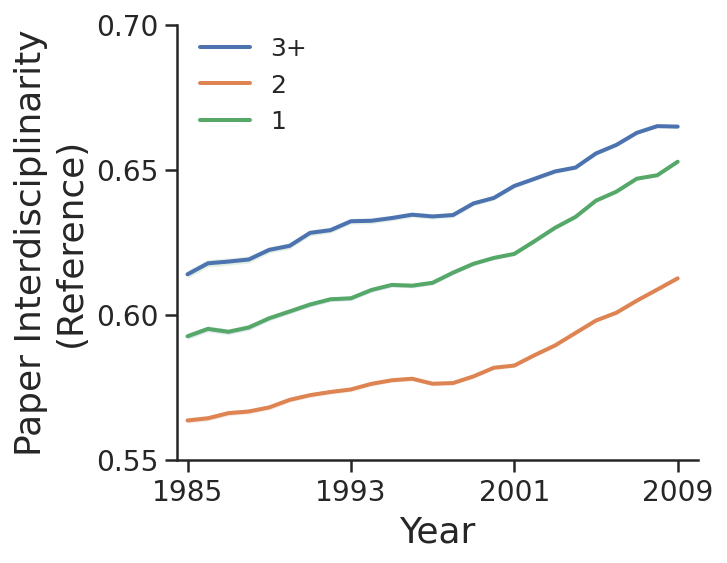

In [84]:
fig, ax = plt.subplots(figsize=(14*(1/3),4))

tmp_x = []
tmp_mu = []
tmp_ci = []
for i in [25,75,100]:
    tmp_x.append(paperITD_per_year_num_fos[paperITD_per_year_num_fos['num_fos_interval']==i]['pub_year'])
    tmp_mu.append(paperITD_per_year_num_fos[paperITD_per_year_num_fos['num_fos_interval']==i]['interdisciplinarity_reference_mean'])
    tmp_ci.append(paperITD_per_year_num_fos[paperITD_per_year_num_fos['num_fos_interval']==i]['interdisciplinarity_reference_ci'])

for i,label in reversed(list(enumerate(['1','2','3+']))):
    ax.plot(tmp_x[i], tmp_mu[i], lw=2, label=label)
    ax.fill_between(tmp_x[i], tmp_mu[i]+tmp_ci[i], tmp_mu[i]-tmp_ci[i],
                    facecolor='C{}'.format(i), alpha=0.2)

ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Paper Interdisciplinarity\n(Reference)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.xticks([1985, 1993, 2001, 2009])
ax.set_xticklabels(['1985', '1993', '2001', '2009'])
plt.xlim(1984.5, 2010)
plt.yticks([0.55, 0.60, 0.65, 0.70])
ax.set_yticklabels(['0.55', '0.60', '0.65', '0.70'])
plt.ylim(0.55, 0.70)

ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.025),
          fontsize=12.5, frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)